In [2]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

matplotlib.style.use('ggplot')

In [3]:
trans = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
train_set = datasets.MNIST(root="./", train=True, transform=trans)
test_set = datasets.MNIST(root="./", train=False, transform=trans)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

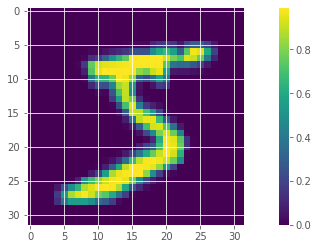

In [3]:
fig = plt.figure(figsize=(12, 4))
im = plt.imshow(train_set.__getitem__(0)[0].numpy().squeeze())
fig.colorbar(im)

#### Training VAE

In [4]:
from VAE import VAE

n_channel = 1
z_dim = 16
hdims = [8, 16, 32, 64]
eps = 1e-100
counter = 0
device = "cuda:0" if torch.cuda.is_available() else "cpu"
vae = VAE(n_channel, z_dim, hdims).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=0.001)

In [5]:
train_loss = []
test_loss = []

for epoch in range(100):
    mean_train_loss = 0
    vae = vae.train()
    for i, (X_train, _) in enumerate(train_loader):
        X_train = X_train.to(device)
        recons, mu, logvar = vae(X_train)
        tr_loss = vae.compute_loss(X_train, recons, mu, logvar)
        opt.zero_grad()
        tr_loss.backward()
        opt.step()
        train_loss.append(tr_loss.item())
        mean_train_loss += tr_loss
        
    if (epoch+1)%10==0:
        print(f"train_loss: {mean_train_loss/(i+1)}")
        vae = vae.eval()
        mean_test_loss = 0
        for j, (X_test, _) in enumerate(test_loader):
            X_test = X_test.to(device)
            recons, mu, logvar = vae(X_test)
            te_loss = vae.compute_loss(X_test, recons, mu, logvar)
            test_loss.append(te_loss.item())
            mean_test_loss += te_loss
            
        print(f"test_loss: {mean_test_loss/(i+1)}")
    

train_loss: 9713.2333984375
test_loss: 1614.1995849609375
train_loss: 9543.2958984375
test_loss: 1583.121826171875
train_loss: 9476.7724609375
test_loss: 1581.3258056640625
train_loss: 9425.716796875
test_loss: 1569.86279296875
train_loss: 9385.1259765625
test_loss: 1565.209716796875
train_loss: 9360.228515625
test_loss: 1559.8671875
train_loss: 9339.9140625
test_loss: 1554.939697265625
train_loss: 9316.4951171875
test_loss: 1548.0047607421875
train_loss: 9298.4345703125
test_loss: 1544.1158447265625
train_loss: 9286.5859375
test_loss: 1543.86181640625


In [10]:
print(len(train_loss), len(test_loss))

93800 1570


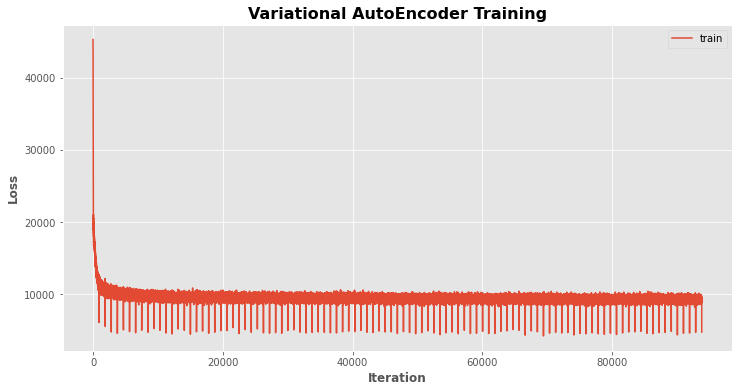

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='train')
plt.xlabel("Iteration", fontsize=12, fontweight='bold')
plt.ylabel("Loss", fontsize=12, fontweight='bold')
plt.title("Variational AutoEncoder Training", fontsize=16, fontweight='bold')
plt.legend(loc='best')

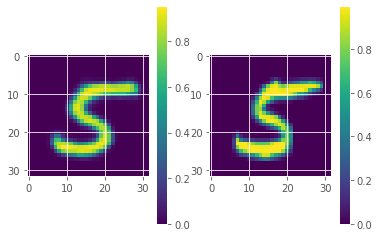

In [7]:
outp = vae.generate(X_test[-5].unsqueeze(0)).squeeze()
fig, axes = plt.subplots(1, 2)
im_0 = axes[0].imshow(outp.cpu().detach().numpy())
fig.colorbar(im_0, ax=axes[0])
im_1 = axes[1].imshow(X_test[-5].cpu().numpy().squeeze())
fig.colorbar(im_1, ax=axes[1])

In [27]:
X_test = X_test.cpu()
vae = vae.cpu()
or_images = []
recons_images = [] 
for i in range(16):
    or_images.append(X_test[i].unsqueeze(0).numpy().squeeze())
    recons_images.append(vae.generate(X_test[i].unsqueeze(0)).squeeze().detach().numpy())

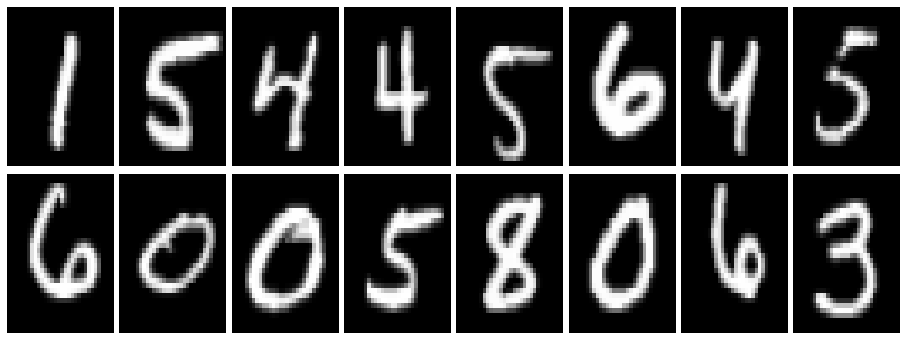

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16,6))
for idx, image in enumerate(or_images):
    row = idx // 8
    col = idx % 8
    axes[row, col].axis("off")
    axes[row, col].imshow(image, cmap="gray", aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

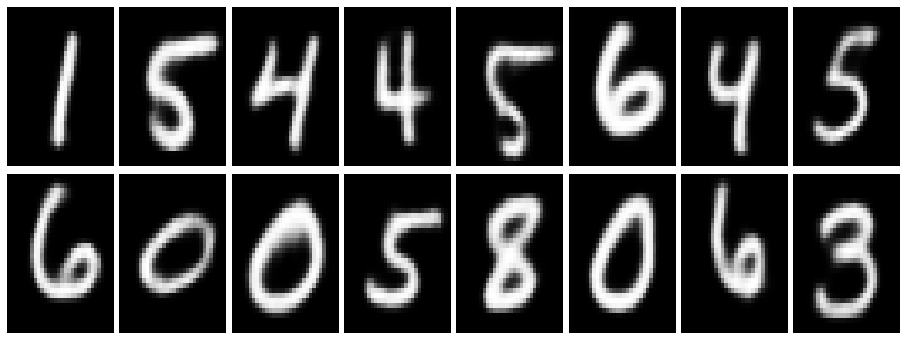

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16,6))
for idx, image in enumerate(recons_images):
    row = idx // 8
    col = idx % 8
    axes[row, col].axis("off")
    axes[row, col].imshow(image, cmap="gray", aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

In [30]:
torch.save(vae.state_dict(), "VAE_mnist.pt")